In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

<ipython-input-73-a669a492ca22>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [77]:
df = pd.read_csv('/content/storms.csv')
df.head(10)

,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
3,4,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
4,5,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN
5,6,Amy,1975,6,28,6,32.4,-78.7,tropical depression,NaN,25,1012,NaN,NaN
6,7,Amy,1975,6,28,12,33.3,-78.0,tropical depression,NaN,25,1011,NaN,NaN
7,8,Amy,1975,6,28,18,34.0,-77.0,tropical depression,NaN,30,1006,NaN,NaN
8,9,Amy,1975,6,29,0,34.4,-75.8,tropical storm,NaN,35,1004,NaN,NaN
9,10,Amy,1975,6,29,6,34.0,-74.8,tropical storm,NaN,40,1002,NaN,NaN


In [78]:
columns_to_drop = ['Unnamed: 0', 'name', 'year', 'month', 'day', 'hour', 'lat', 'long', 'category', 'tropicalstorm_force_diameter', 'hurricane_force_diameter']
df = df.drop(columns_to_drop, axis=1)

In [79]:
df.head()

,status,wind,pressure
0,tropical depression,25,1013
1,tropical depression,25,1013
2,tropical depression,25,1013
3,tropical depression,25,1013
4,tropical depression,25,1012


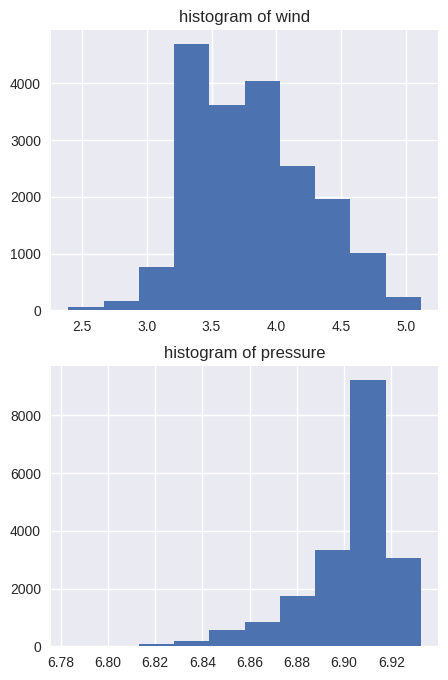

In [80]:
# natural logarithm scaling (+1 to prevent errors at 0)
df.loc[:, ['wind', 'pressure']] = df.loc[:, ['wind', 'pressure']].apply(lambda x: np.log(x + 1), axis = 1)
# visualizing
fig, ax = plt.subplots(2, figsize = (5, 8))
ax[0].hist(df['wind'])
ax[0].title.set_text('histogram of wind')
ax[1].hist(df['pressure'])
ax[1].title.set_text('histogram of pressure')

In [81]:
features = df.drop(['status'], axis = 1)
labels = df['status'].values.reshape(-1, 1)

In [82]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Perform label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Perform one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [83]:
X_train, X_test, y_train, y_test = train_test_split(features,encoded_labels, test_size = 0.2, stratify=encoded_labels)

In [84]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
# fitting scaler
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
# y_test = pd.DataFrame(y_test, columns = ['size_category'])
# y_train = pd.DataFrame(y_train, columns = ['size_category'])
X_train.head()

,wind,pressure
0,0.943919,-1.443542
1,1.473309,-0.804808
2,-3.033836,1.116444
3,-0.227378,0.346127
4,-0.823758,0.655630


In [86]:
len(X_test), len(X_train), len(y_train), len(y_test), df['status'].nunique()

(3814, 15252, 15252, 3814, 9)

In [90]:
model = Sequential()
# input layer + 1st hidden layer
model.add(Dense(128, input_dim=2, activation='relu', kernel_initializer=glorot_uniform(seed=42)))
# 2nd hidden layer
model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=42)))
# output layer
model.add(Dense(32, activation='relu', kernel_initializer=glorot_uniform(seed=42)))
model.add(Dropout(0.2))
model.add(Dense(9, activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               384       
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 9)                 297       
                                                                 
Total params: 11,017
Trainable params: 11,017
Non-trainable params: 0
_________________________________________________________________


In [88]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [91]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='categorical_crossentropy')
model_path = "hurricane2.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 100, callbacks=[checkpoint_callback])

Epoch 1/100
471/477 [============================>.] - ETA: 0s - loss: 0.8852 - accuracy: 0.7410
Epoch 1: val_accuracy improved from -inf to 0.79733, saving model to hurricane2.h5
477/477 [==============================] - 4s 4ms/step - loss: 0.8832 - accuracy: 0.7414 - val_loss: 0.6525 - val_accuracy: 0.7973
Epoch 2/100
465/477 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.7921
Epoch 2: val_accuracy did not improve from 0.79733
477/477 [==============================] - 2s 4ms/step - loss: 0.6624 - accuracy: 0.7922 - val_loss: 0.6149 - val_accuracy: 0.7960
Epoch 3/100
472/477 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.7969
Epoch 3: val_accuracy improved from 0.79733 to 0.80414, saving model to hurricane2.h5
477/477 [==============================] - 3s 6ms/step - loss: 0.6289 - accuracy: 0.7967 - val_loss: 0.6033 - val_accuracy: 0.8041
Epoch 4/100
466/477 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.7979

In [9]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming you have a DataFrame named 'df' and 'column_name' is the name of the column you want to check

unique_classes = df['status'].unique()
print("Unique classes:")
for class_label in unique_classes:
    print(class_label)


Unique classes:
1
0


In [92]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.806, Valid: 0.806


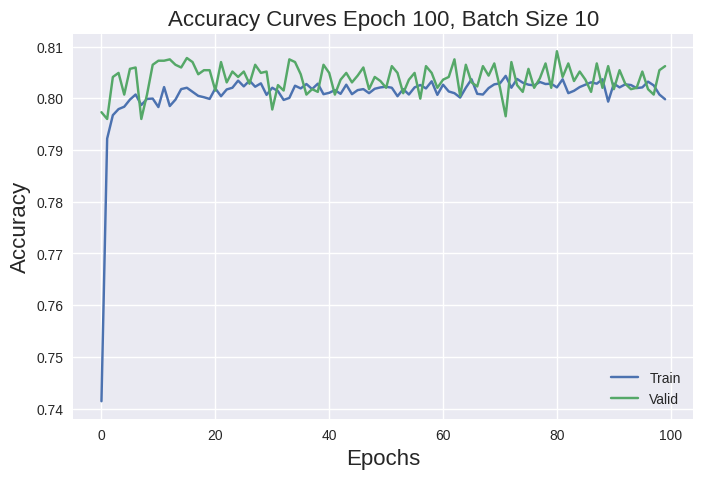

In [93]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()